In [1]:
# 필요한 module Download
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# cuda가 존재할 경우 gpu사용, 아닐 경우 cpu
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print("Current cuda device is", device)

Current cuda device is  cpu


In [3]:
# Hyper Parameter Settings
batch_size = 50
epoch_num = 15
learning_rate = 1e-4

In [4]:
# MNIST DATA DOWNLOADING
# parameter 中 transform : 데이터들을 tensor 형태로 변형한다.
train_data = datasets.MNIST(root = './data', train = True, download = True, transform = transforms.ToTensor())
test_data = datasets.MNIST(root = './data', train = False, transform = transforms.ToTensor())

print("number of training data:", len(train_data))
print("number of test data:", len(test_data))

100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



102.8%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



112.7%

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

number of training data: 60000
number of test data: 10000



C:\Users\user\anaconda3\envs\deep_class\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


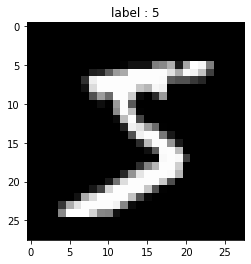

In [5]:
# MNIST DATA CHECK
image, label = train_data[0]

plt.imshow(image.squeeze().numpy(), cmap = "gray")
plt.title("label : %s" % label)
plt.show()

In [9]:
# small batch compose
# parameter 中 shuffle : 말 그대로 shuffle. 데이터 사용할 때 섞어서 사용한다는 뜻.
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)

first_batch = train_loader.__iter__().__next__()
print("{:15s} | {:<25s} | {}".format("name", "type", "size"))
print("{:15s} | {:<25s} | {}".format("Num of Batch", "", len(train_loader)))
print("{:15s} | {:<25s} | {}".format("first_batch", str(type(first_batch)), len(first_batch)))
print("{:15s} | {:<25s} | {}".format("first_batch[0]", str(type(first_batch[0])), first_batch[0].shape))
print("{:15s} | {:<25s} | {}".format("first_batch[1]", str(type(first_batch[1])), first_batch[1].shape))

name            | type                      | size
Num of Batch    |                           | 1200
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([50, 1, 28, 28])
first_batch[1]  | <class 'torch.Tensor'>    | torch.Size([50])


In [10]:
# CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)      # Conv2d의 parameter는 무엇을 의미? : (input channel size, pixel, pixel, padding)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)       # dropout이란? : Overfitting 방지를 위한 방법으로 일종의 치매!
        self.dropout2 = nn.Dropout2d(0.5)
        # fully connected 설정 방법? : Output Size = (input volume size - kernel_size + 2 * padding size) / stride + 1.
        # 즉, conv1 => (32 - 3 + 2*1) / 1 + 1 = 32. stride는 default 값이 1이다.
        # Maxpooling이 있다면 Maxpooling 값으로 나눈 값이 Output Size
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        # flatten(평탄화)란? : 다차원 형태의 행렬을 통합하여 놓음! 파라미터가 하나라면 [원소들], 두 번째 파라미터가 1이라면 [[원소 일부], [원소 일부]]의 형태
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        # softmax란? : 입력받은 값을 출력으로 0~1사이의 값으로 모두 정규화하며 출력 값들의 총합은 항상 1이 되는 특성을 가진 함수(출처 : https://wikidocs.net/35476)
        # 즉, 각 값들일 확률을 나타낸다는 것!
        output = F.log_softmax(x, dim = 1)
        return output

In [18]:
# Optimizer and Loss Function define
model = CNN().to(device)
# Optimizer란? : Hyper Parameter를 조정하는 역할!
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
# Loss Function 종류는? : MSE, RMSE, CrossEntropy 등 다양하며 각각의 성질도 다르다!
criterion = nn.CrossEntropyLoss()

In [19]:
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [20]:
# Model Training
model.train()
i = 0
for epoch in range(epoch_num):
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        # zero_grad : 미분을 통해 얻은 기울기를 0으로 초기화 : 새로운 가중치 편향에 대해 새로운 기울기를 구하고자 함. 출처 : https://wikidocs.net/53560
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if i % 1000 == 0:
            print("Train Step: {}\tLoss: {:.3f}".format(i, loss.item()))
        i += 1

Train Step: 0	Loss: 2.277
Train Step: 1000	Loss: 0.315
Train Step: 2000	Loss: 0.268
Train Step: 3000	Loss: 0.118
Train Step: 4000	Loss: 0.154
Train Step: 5000	Loss: 0.135
Train Step: 6000	Loss: 0.069
Train Step: 7000	Loss: 0.032
Train Step: 8000	Loss: 0.103
Train Step: 9000	Loss: 0.052
Train Step: 10000	Loss: 0.034
Train Step: 11000	Loss: 0.044
Train Step: 12000	Loss: 0.017
Train Step: 13000	Loss: 0.142
Train Step: 14000	Loss: 0.181
Train Step: 15000	Loss: 0.103
Train Step: 16000	Loss: 0.008
Train Step: 17000	Loss: 0.013


In [21]:
# Model Evaluation
model.eval()
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum()

print("Test set: Accuracy: {:.2f}%".format(100 * correct / len(test_loader.dataset)))

Test set: Accuracy: 98.98%
